In [1]:
import os
import sys
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [2]:
root = "./stanford-dogs-dataset/images/Images/"
thumbroot = "./thumbnails/"

In [3]:
## Helper Functions

def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def getAnnotations(ann_path):
    tree = ET.parse(ann_path)
    root = tree.getroot()
    xmin = int(root.find("object/bndbox/xmin").text)
    ymin = int(root.find("object/bndbox/ymin").text)
    xmax = int(root.find("object/bndbox/xmax").text)
    ymax = int(root.find("object/bndbox/ymax").text)
    return (xmin, ymin, xmax, ymax)

def getAnnpath(img_path):
    ann_path = img_path.replace("images", "annotations").replace("Images", "Annotation")
    ann_path = os.path.splitext(ann_path)[0]
    return ann_path

In [4]:
## Generate Label Dictionary (id, label)

dictionary={}
subdirs = os.listdir(root)
for dir in subdirs:
    key = dir.split("-", 1)[0]
    value = dir.split("-", 1)[1]
    dictionary[key] = value

In [5]:
## Data Size
print("Calculating data size ...")

count = 0
heights = []
widths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
        count += 1
        sys.stdout.write("Progress calculating: {:.2%}\r".format(count/20580))
        sys.stdout.flush()

min_height = min(heights)
min_width = min(widths)
total = count

Calculating data size ...


In [6]:
print("Number of image: ", total)
print("Min image height: ", min_height)
print("Min image width: ", min_width)

Number of image:  20580
Min image height:  100
Min image width:  97


In [7]:
## Generate cropped, same-sized, grey-scaled images in another file
print("Generating same-sized, grey-scaled images ...")

# Check if old files exists
files = os.listdir(thumbroot)
if files:
    for f in files:
        os.unlink(os.path.join(thumbroot, f))
    
# Start generating 
count = 0
for path, subdirs, files in os.walk(root):
    for name in files:
        img_path = os.path.join(path, name)
        thumb_path = os.path.join(thumbroot, name)
        ann_path = getAnnpath(img_path)
        
        img = Image.open(img_path)
        cr_img = img.crop(getAnnotations(ann_path))
        re_img = cr_img.resize((100, 100), Image.ANTIALIAS)
        gr_img = re_img.convert("L")
        gr_img.save(thumb_path, quality=95)

        count += 1
        writeProgress("Progress generating images: ", count, total)

Generating same-sized, grey-scaled images ...


In [8]:
## Read Image to ndarray
print("Reading images ...")

images = []
labels = []
count = 0

for name in os.listdir(thumbroot):
    img_path = os.path.join(thumbroot, name)
    img = mpimg.imread(img_path)
    images.append(img)

    key = name.split("_", 1)[0]
    label = dictionary[key]
    labels.append(label)

    count += 1
    writeProgress("Progress loading images: ", count, total)

X = np.array(images)
Y = np.array(labels)

Reading images ...


In [9]:
## Data Size (after resizing)
print("X shape: ", X.shape)
print("Y size: ", Y.size)

X shape:  (20580, 100, 100)
Y size:  20580


(100, 100)


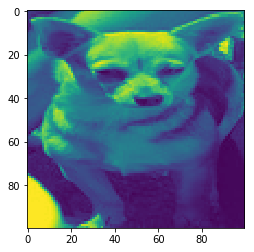

In [10]:
plt.imshow(X[0])
print(X[0].shape)

In [11]:
## Flaten Image List (bcuz NMF only consumes 2D data)

X_flat = np.array(X).reshape((X.shape[0], X.shape[1]*X.shape[2]))

In [12]:
## Split Test / Train
print("Spliting Test / Train sets ...")

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

Spliting Test / Train sets ...


In [13]:
## Data Size (after spliting)
print("X train shape: ", X_train.shape)
print("Y train size: ", y_train.size)
print("X test shape: ", X_test.shape)
print("Y test size: ", y_test.size)

X train shape:  (14406, 10000)
Y train size:  14406
X test shape:  (6174, 10000)
Y test size:  6174


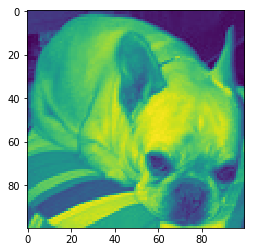

In [14]:
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

In [15]:
## NMF
print("NMF ...")

nmf = NMF(n_components=1500, init='random', random_state=0, tol=0.1, verbose=True)

W = nmf.fit_transform(X_train)
H = nmf.components_

NMF ...
violation: 1.0
violation: 0.19427102997942244
violation: 0.10577976986021398
violation: 0.08013408724135682
Converged at iteration 4


In [16]:
X_reduced = W
X_recovered = nmf.inverse_transform(X_reduced)

In [17]:
## Data Size
print("Reduced Shape: " + str(X_reduced.shape))
print("Recovered Shape: " + str(X_recovered.shape))

Reduced Shape: (14406, 1500)
Recovered Shape: (14406, 10000)


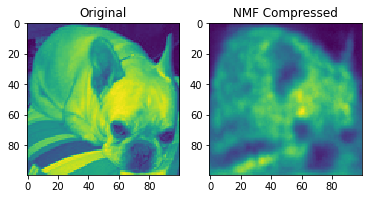

In [18]:
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

f.add_subplot(1,2, 2)
plt.title("NMF Compressed")
plt.imshow(X_recovered[0].reshape(X.shape[1], X.shape[2]))

plt.show(block=True)

In [53]:
## Classification - MLP (reduced)
print("Classifying reduced images ...")

# Training
print("Training ...")

mlp_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1, verbose=True)
mlp_reduced.fit(X_reduced, y_train)

# Testing
print("Testing ...")

X_test_reduced = nmf.transform(X_test)
y_hat_reduced = mlp_reduced.predict(X_test_reduced)

Classifying reduced images ...
Training ...
Iteration 1, loss = 5.18375887
Iteration 2, loss = 4.79224792
Iteration 3, loss = 4.77374997
Iteration 4, loss = 4.73086509
Iteration 5, loss = 4.63829225
Iteration 6, loss = 4.54876451
Iteration 7, loss = 4.46488541
Iteration 8, loss = 4.38064781
Iteration 9, loss = 4.31069267
Iteration 10, loss = 4.24845771
Iteration 11, loss = 4.20482578
Iteration 12, loss = 4.16883811
Iteration 13, loss = 4.12687459
Iteration 14, loss = 4.08403970
Iteration 15, loss = 4.04606037
Iteration 16, loss = 4.00945766
Iteration 17, loss = 3.96816857
Iteration 18, loss = 3.93995398
Iteration 19, loss = 3.90482981
Iteration 20, loss = 3.88477228
Iteration 21, loss = 3.83995141
Iteration 22, loss = 3.81809728
Iteration 23, loss = 3.79520260
Iteration 24, loss = 3.76061914
Iteration 25, loss = 3.73563360
Iteration 26, loss = 3.70832314
Iteration 27, loss = 3.68337878
Iteration 28, loss = 3.65933991
Iteration 29, loss = 3.63006720
Iteration 30, loss = 3.61509305
Itera

c:\users\vicky lin\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


violation: 1.0
violation: 0.6977733308280961
violation: 0.5304569641952742
violation: 0.4452328405515272
violation: 0.3923537229918359
violation: 0.3556779693402715
violation: 0.3271379428981778
violation: 0.30332485587714914
violation: 0.28133310287906244
violation: 0.2629352754516743
violation: 0.2474309323635252
violation: 0.23321702015725493
violation: 0.2205418722547822
violation: 0.2086719676697587
violation: 0.19868585392209787
violation: 0.18961097965206866
violation: 0.18120267377362909
violation: 0.1731811627530502
violation: 0.16608873653293568
violation: 0.1590181879407883
violation: 0.15267320392578979
violation: 0.14680598513081217
violation: 0.1412191946960333
violation: 0.1360658226113913
violation: 0.1313767719200654
violation: 0.1270081212039067
violation: 0.12275089315468246
violation: 0.11871936273905874
violation: 0.11485752904148469
violation: 0.1111499986732912
violation: 0.10760670690743096
violation: 0.10428607514070547
violation: 0.10121443409769615
violation:

In [19]:
svm_reduced = SVC(kernel='linear', probability=True, verbose=True)
svm_model = svm_reduced.fit(X_reduced, y_train)
y_score = svm_model.decision_function(X_test)
print(y_score)

[LibSVM]

ValueError: X.shape[1] = 10000 should be equal to 1500, the number of features at training time

In [78]:
## Evaluations of reduced images
print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))
print("precision: " + str(precision_score(y_test, y_hat_reduced, average=None)))
print("recall: " + str(recall_score(y_test, y_hat_reduced, average=None)))
print("F1: " + str(f1_score(y_test, y_hat_reduced, average=None)))

def myFunc(key):
    result = []
    for (i, cl) in enumerate(y_hat_reduced):
        if cl == key: 
            if y_test[i] == key:
                result.append(1)
        else: result.append(0)
    print(result)
    return result

print(mlp_reduced)
n_classes = 120
plt.figure()
for (i, value) in enumerate(dictionary.values()):
#     y_test_bi = myFunc(value)
#     y_hat_reduced_bi = myFunc(value)
    fpr, tpr, _ = roc_auc_score(y_test, y_hat_reduced, pos_label=value)
    print(value, fpr, tpr)
    roc_auc = auc(fpr, tpr)

    # Plot of a ROC curve for a specific class
    f.add_subplot(60, 2, i+1)
    plt.title(value)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

accuracy: 0.01635892452218983
precision: [0.         0.02439024 0.         0.         0.01785714 0.
 0.         0.01898734 0.01829268 0.01282051 0.08       0.01190476
 0.         0.         0.02       0.01639344 0.         0.
 0.02941176 0.         0.02222222 0.0212766  0.         0.01408451
 0.03030303 0.         0.         0.         0.04       0.
 0.2        0.         0.03125    0.         0.         0.
 0.         0.01369863 0.01748252 0.15384615 0.         0.
 0.00833333 0.         0.04166667 0.         0.11764706 0.
 0.02941176 0.         0.04545455 0.         0.         0.
 0.         0.01818182 0.02808989 0.         0.         0.04545455
 0.         0.04       0.         0.03252033 0.05714286 0.
 0.         0.0625     0.01587302 0.02164502 0.         0.01298701
 0.         0.25       0.1        0.         0.00641026 0.
 0.         0.         0.         0.         0.         0.
 0.125      0.         0.         0.03030303 0.03846154 0.00775194
 0.03333333 0.         0.03703704 

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U30') dtype('<U30') dtype('<U30')

<Figure size 432x288 with 0 Axes>

In [55]:
## Classification - MLP (original)
print("Classifying original images ...")

# Training
print("Training ...")

mlp_orgn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1, verbose=True)
mlp_orgn.fit(X_train, y_train)

Classifying original images ...
Training ...
Iteration 1, loss = 6.32249687
Iteration 2, loss = 4.79009486
Iteration 3, loss = 4.78745495
Iteration 4, loss = 4.78534716
Iteration 5, loss = 4.78356136
Iteration 6, loss = 4.78221776
Iteration 7, loss = 4.78125996
Iteration 8, loss = 4.78045411
Iteration 9, loss = 4.77975707
Iteration 10, loss = 4.77932306
Iteration 11, loss = 4.77895034
Iteration 12, loss = 4.77870300
Iteration 13, loss = 4.77841817
Iteration 14, loss = 4.77832446
Iteration 15, loss = 4.77821211
Iteration 16, loss = 4.77809906
Iteration 17, loss = 4.77799480
Iteration 18, loss = 4.77795989
Iteration 19, loss = 4.77791231
Iteration 20, loss = 4.77784863
Iteration 21, loss = 4.77787207
Iteration 22, loss = 4.77780675
Iteration 23, loss = 4.77781842
Iteration 24, loss = 4.77778796
Iteration 25, loss = 4.77775891
Iteration 26, loss = 4.77775923
Iteration 27, loss = 4.77772926
Iteration 28, loss = 4.77771620
Training loss did not improve more than tol=0.000100 for 10 consecut

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [56]:
# Testing
print("Testing ...")

y_hat_orgn = mlp_orgn.predict(X_test)

Testing ...


In [57]:
## Evaluations of original images
print("accuracy: " + str(accuracy_score(y_test, y_hat_orgn)))

accuracy: 0.009556203433754453
